In [1]:
import sys
!{sys.executable} -m pip install -U pandas

Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: pandas in /.local/lib/python3.6/site-packages (1.0.3)
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
from tensorflow.python.summary.summary_iterator import summary_iterator

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [4]:
from ShAReD_Net.configure import config

config.dataset.IMG_PATH = "/dataset/jta/images_jpg"
config.dataset.ANNO_PATH = "/dataset/jta/new_image_annotations"

#config.tensorboard.path = "/tf/pose3D/logdir/run17_hard_batch_loss/eval2_train/eval"
config.tensorboard.path = "/tf/pose3D/logdir/run17_hard_batch_loss/eval2/eval"

In [5]:
!ls {config.tensorboard.path}

events.out.tfevents.1588932665.39a473e08e3b.26929.36.v2
events.out.tfevents.1588938248.39a473e08e3b.22136.36.v2


In [6]:
#file = "events.out.tfevents.1588926728.39a473e08e3b.19305.36.v2"
file = "events.out.tfevents.1588938248.39a473e08e3b.22136.36.v2"

In [7]:
steps_to_eval = 5000

In [8]:
import struct
def decode(to_decode):
    v = tf.io.parse_tensor(to_decode.SerializeToString(), out_type =tf.float32).numpy()
    return v

def decode_img(to_decode):
    v = tf.io.parse_tensor(to_decode.SerializeToString(), out_type =tf.string)
    v = tf.io.decode_png(v[2])
    return v

keypoint_count = 15

detection_loss = []
cut_dist = []
keypoints_x = [[] for k in range(keypoint_count)]
keypoints_y = [[] for k in range(keypoint_count)]
keypoints_z = [[] for k in range(keypoint_count)]
keypoints_x_gt = [[] for k in range(keypoint_count)]
keypoints_y_gt = [[] for k in range(keypoint_count)]
keypoints_z_gt = [[] for k in range(keypoint_count)]
steps_kp = []
steps = []

steps_im = []
images = []
poss_f = []
poss_n = []
poss_f_gt = []
poss_n_gt = []

steps_pe = []
persons = []
poses = []
cut_dist_pe = []

i = 0
for e in summary_iterator(config.tensorboard.path + "/" + file):
    i = e.step
    if i > steps_to_eval:
        break
    for v in e.summary.value:
        if v.tag == 'cond/detection_loss':
            steps.append(i)
            detection_loss.append(decode(v.tensor))
            
        if v.tag == 'cond/while/cut_dist':
            cut_dist.append(decode(v.tensor))
            
        if v.tag == 'cond_1/image':
            steps_im.append(i)
            images.append(decode_img(v.tensor))
            
        if v.tag == 'cond_1/pose_imges':
            steps_pe.append(i)
            cut_dist_pe.append(cut_dist[-1])
            persons.append(decode_img(v.tensor)) 
        if v.tag == 'cond_1/pose_hm':
            poses.append(decode_img(v.tensor))
            
        if v.tag == 'cond_1/pos_hm_fare':
            poss_f.append(decode_img(v.tensor))
        if v.tag == 'cond_1/pos_hm_near':
            poss_n.append(decode_img(v.tensor)) 
            
        if v.tag == 'cond_1/pos_hm_gt_fare':
            poss_f_gt.append(decode_img(v.tensor))
        if v.tag == 'cond_1/pos_hm_gt_near':
            poss_n_gt.append(decode_img(v.tensor)) 
            
        for k in range(keypoint_count):
            if v.tag == 'cond/while_'+str(k+1)+'/pose x, kp '+str(k):
                keypoints_x[k].append(decode(v.tensor))
                if k == 0:
                    steps_kp.append(i)
            if v.tag == 'cond/while_'+str(k+1)+'/pose y, kp '+str(k):
                keypoints_y[k].append(decode(v.tensor))
            if v.tag == 'cond/while_'+str(k+1)+'/pose z, kp '+str(k):
                keypoints_z[k].append(decode(v.tensor))
                
            if v.tag == 'cond/while_'+str(k+1)+'/pose gt x, kp '+str(k):
                keypoints_x_gt[k].append(decode(v.tensor))
            if v.tag == 'cond/while_'+str(k+1)+'/pose gt y, kp '+str(k):
                keypoints_y_gt[k].append(decode(v.tensor))
            if v.tag == 'cond/while_'+str(k+1)+'/pose gt z, kp '+str(k):
                keypoints_z_gt[k].append(decode(v.tensor))

                

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


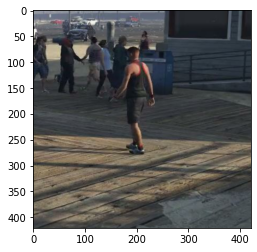

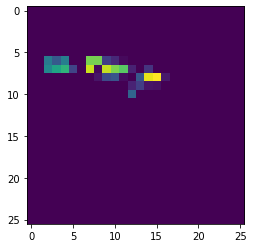

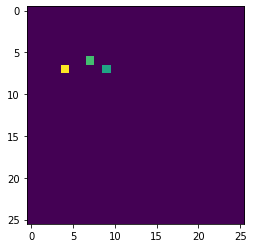

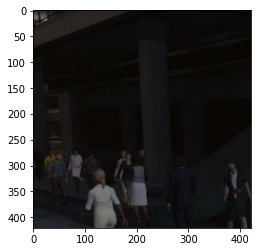

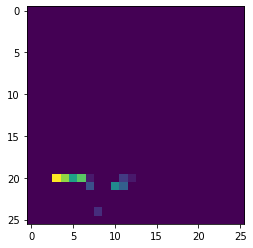

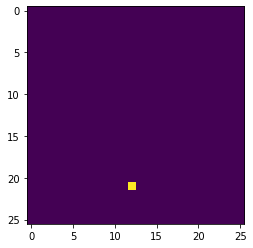

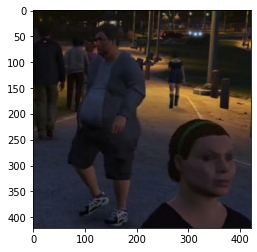

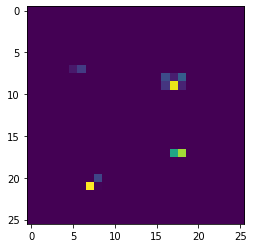

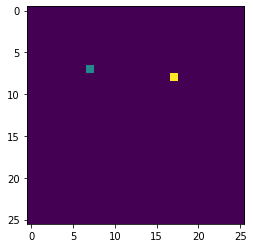

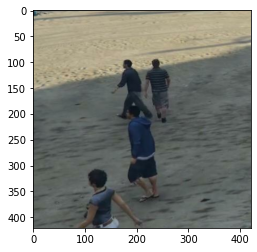

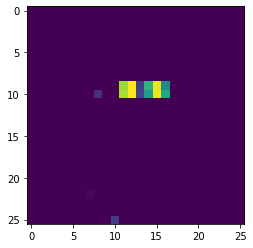

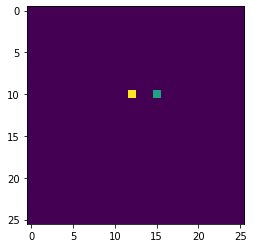

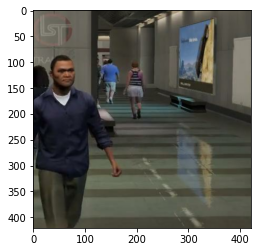

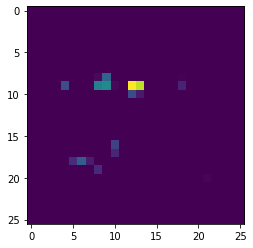

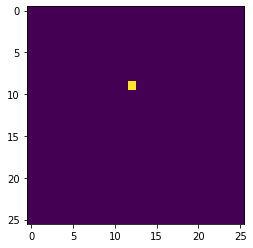

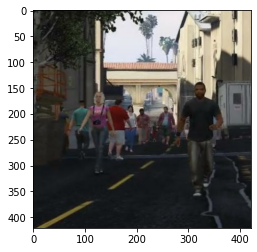

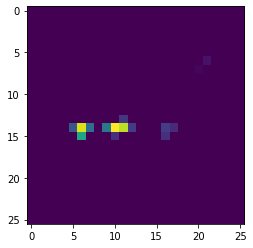

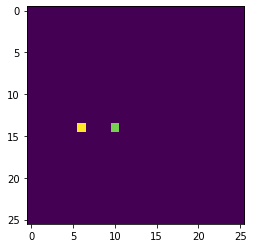

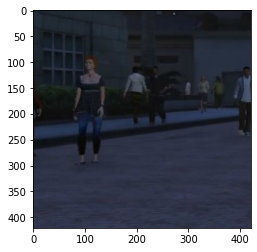

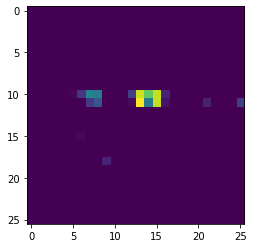

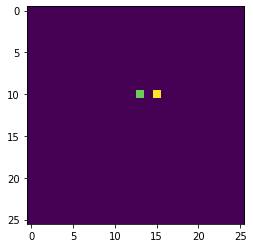

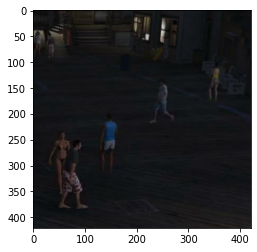

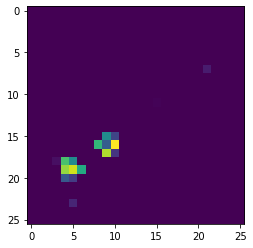

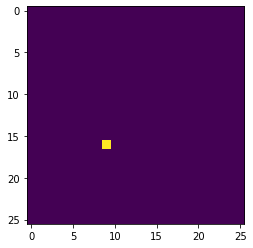

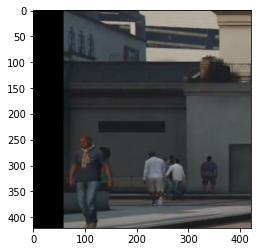

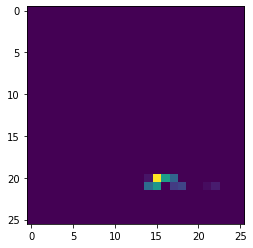

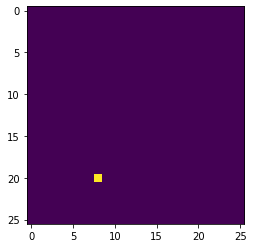

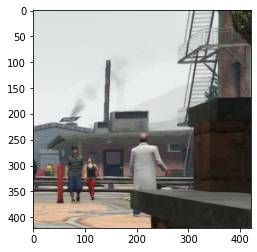

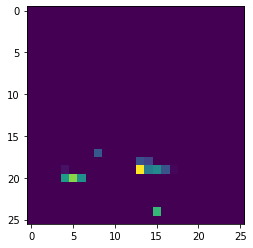

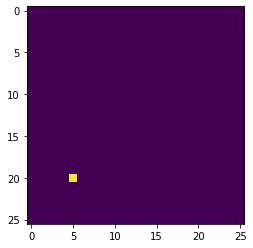

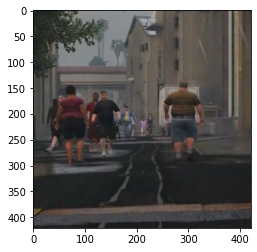

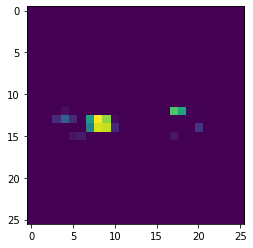

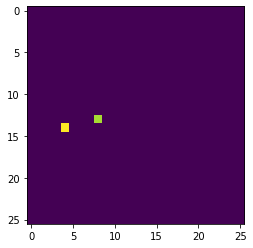

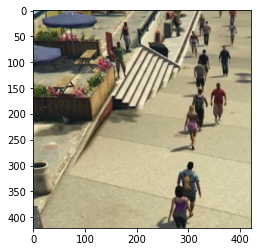

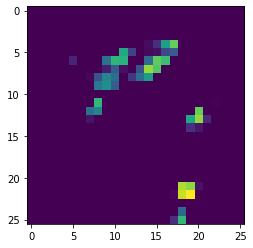

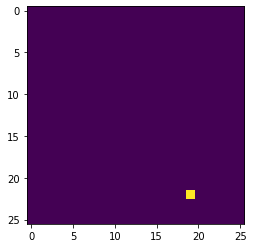

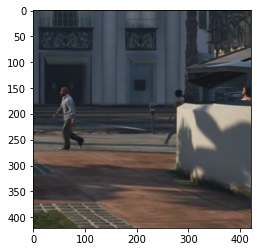

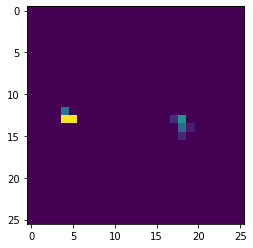

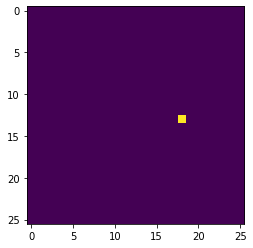

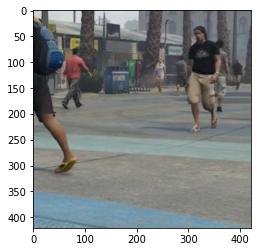

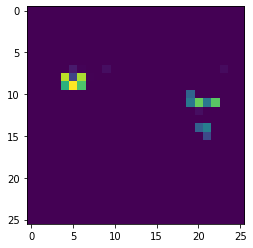

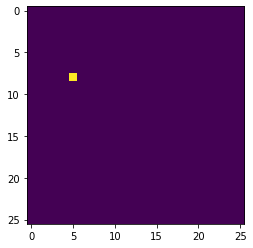

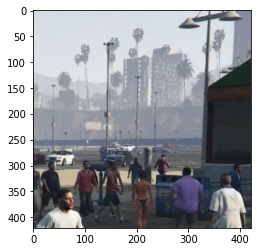

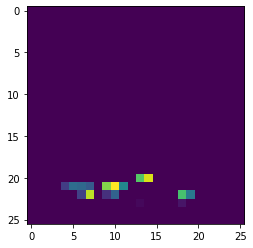

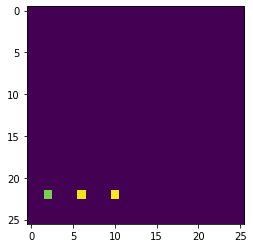

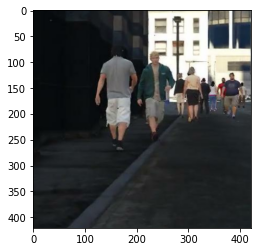

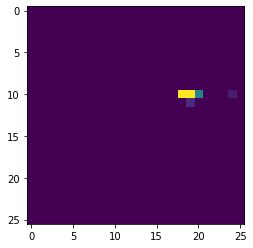

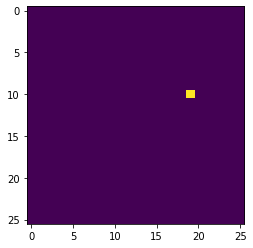

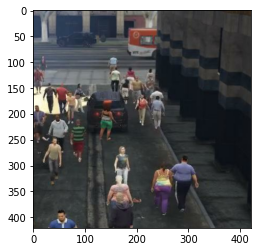

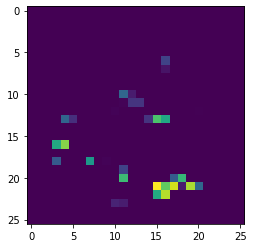

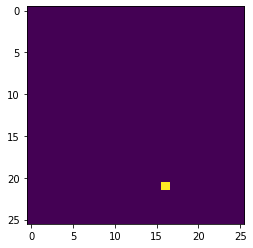

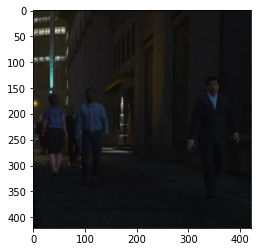

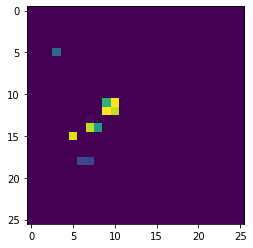

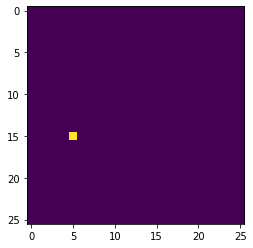

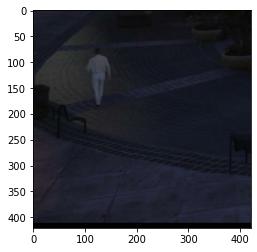

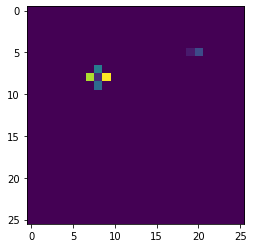

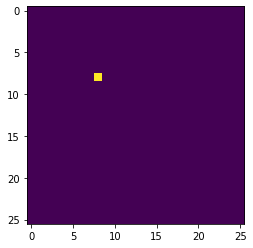

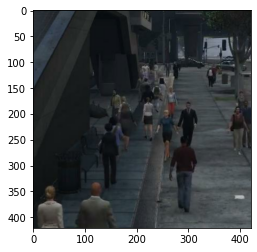

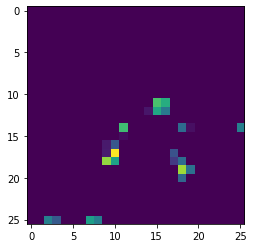

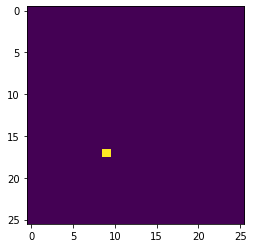

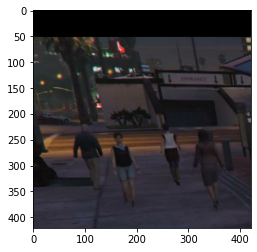

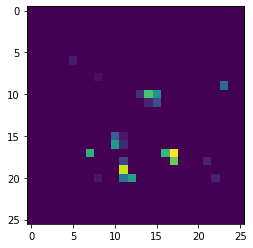

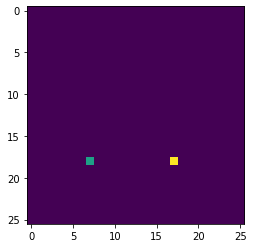

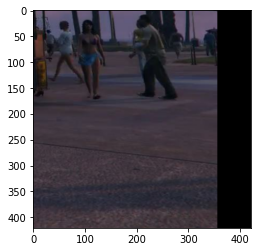

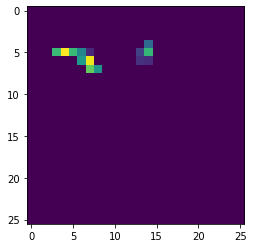

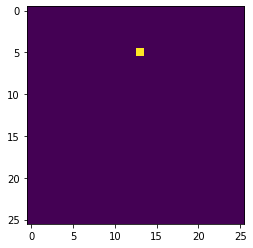

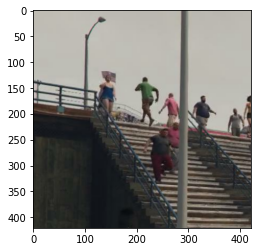

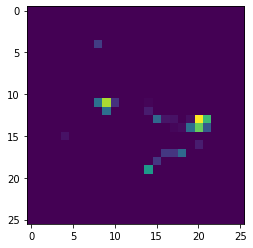

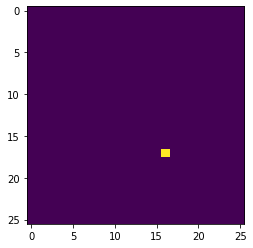

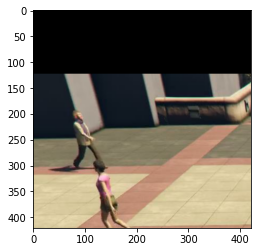

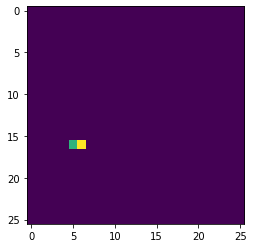

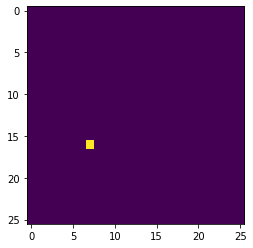

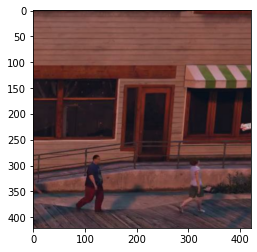

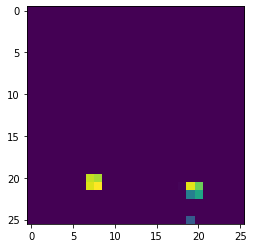

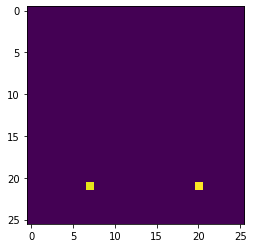

In [9]:
take_every = 20
for i in range(0,len(images),take_every):
    plt.imshow(images[i].numpy())
    plt.show()
    plt.imshow(poss_f[i].numpy()[:,:,0]+poss_n[i].numpy()[:,:,0])
    plt.show()
    plt.imshow(poss_f_gt[i].numpy()[:,:,0]+poss_n_gt[i].numpy()[:,:,0])
    plt.show()
    

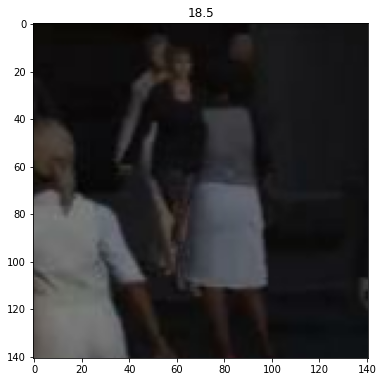

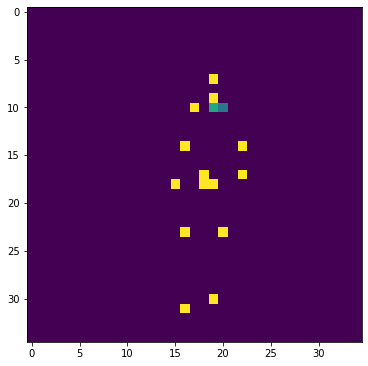

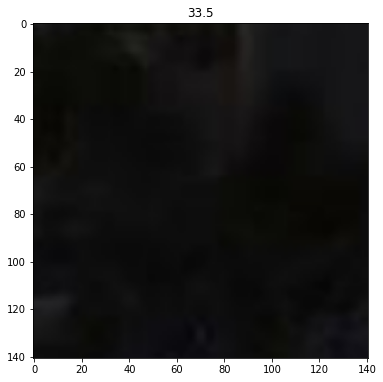

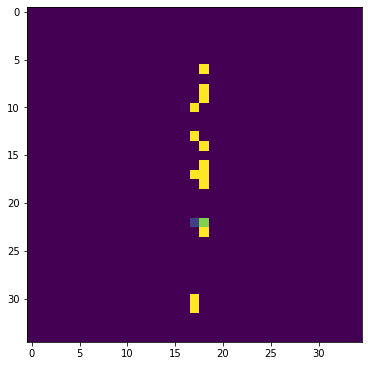

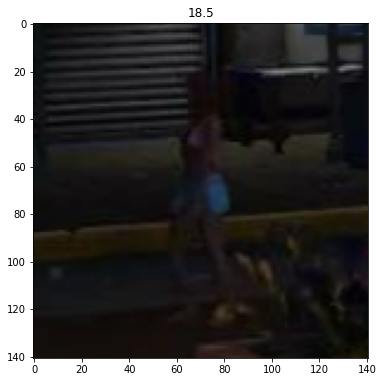

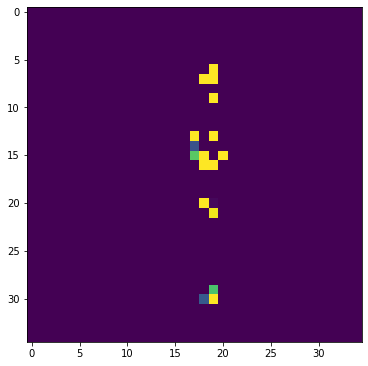

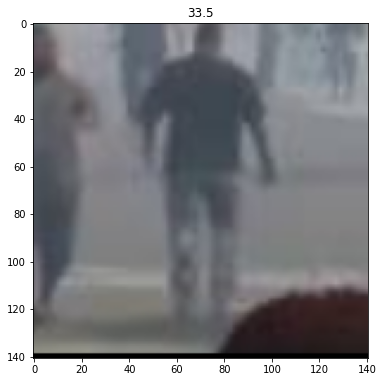

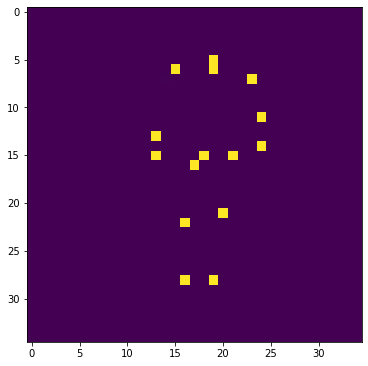

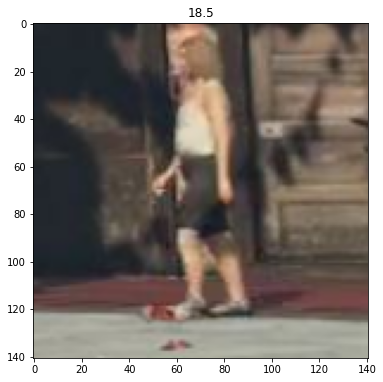

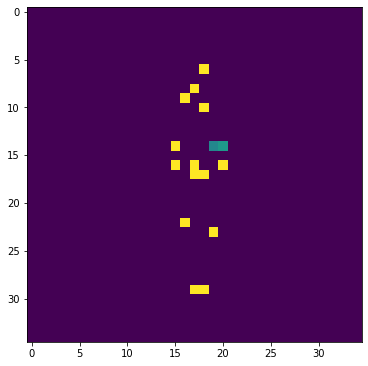

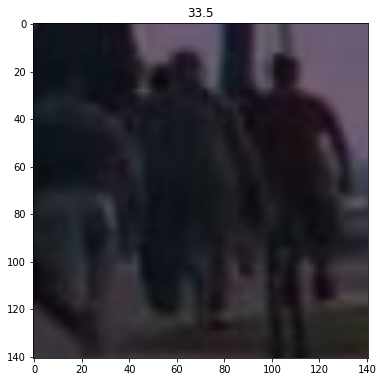

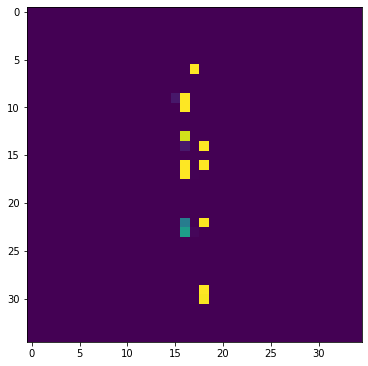

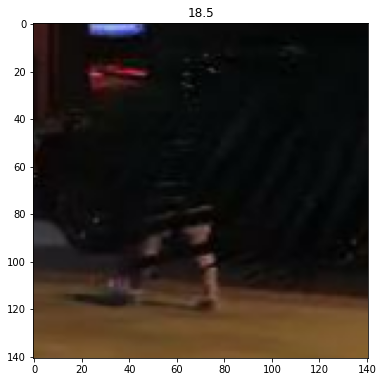

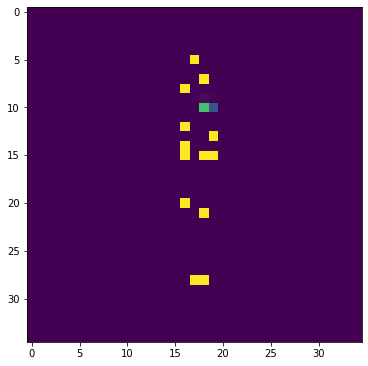

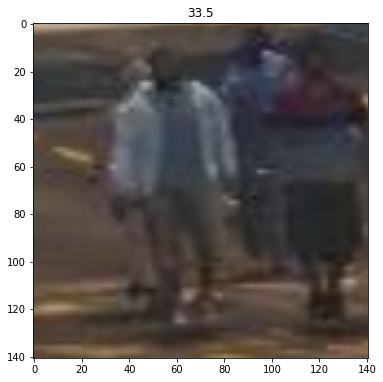

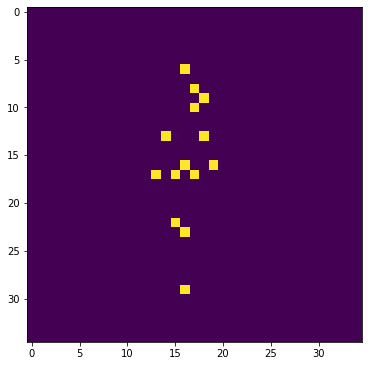

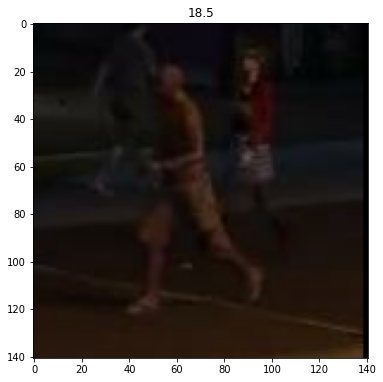

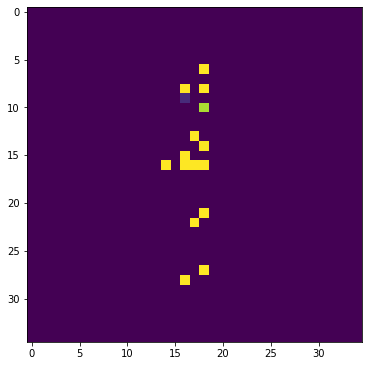

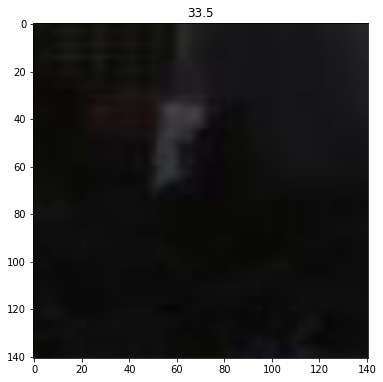

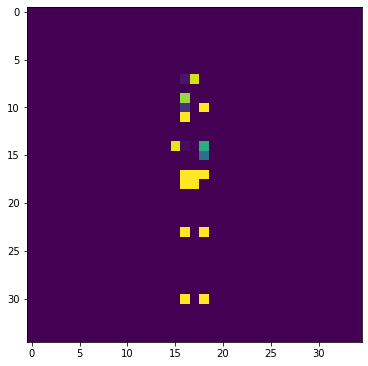

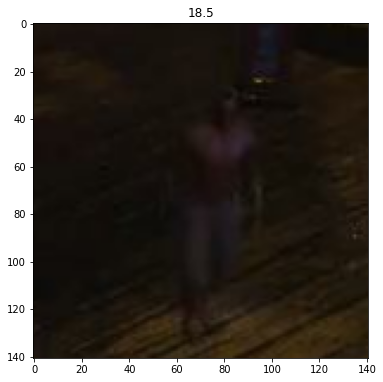

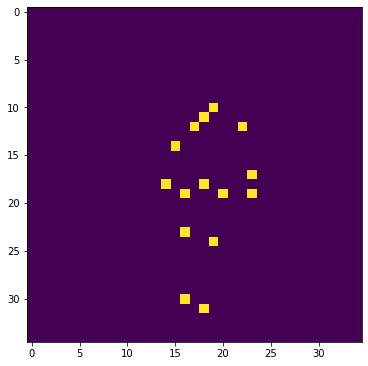

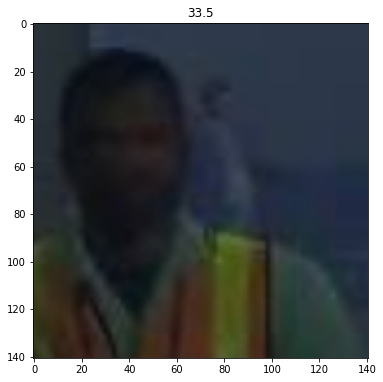

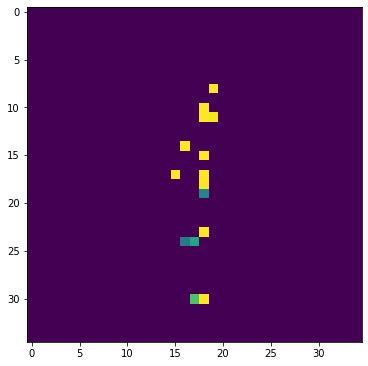

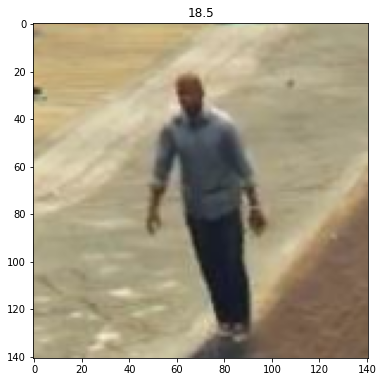

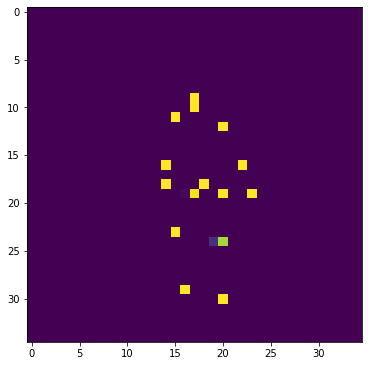

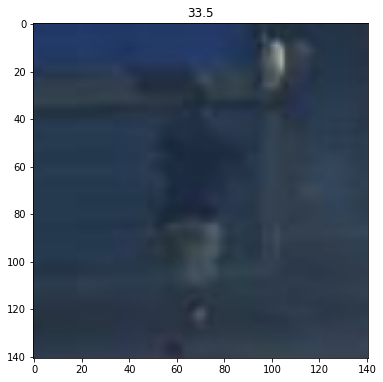

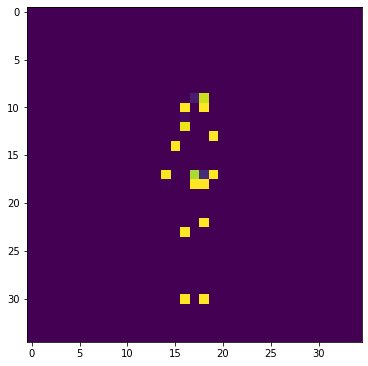

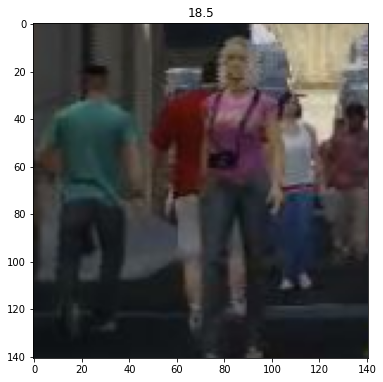

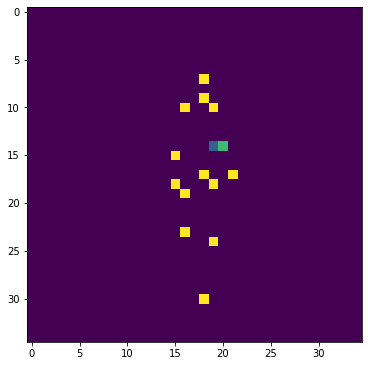

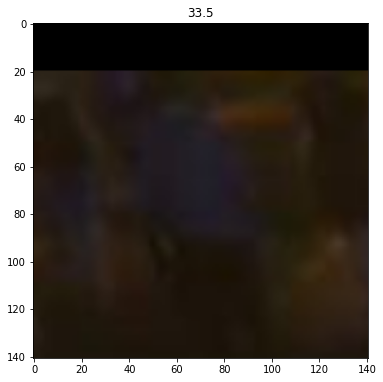

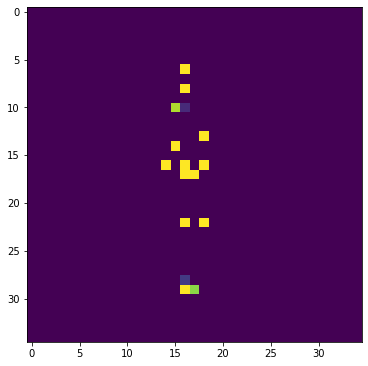

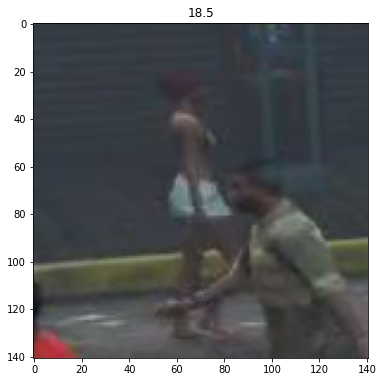

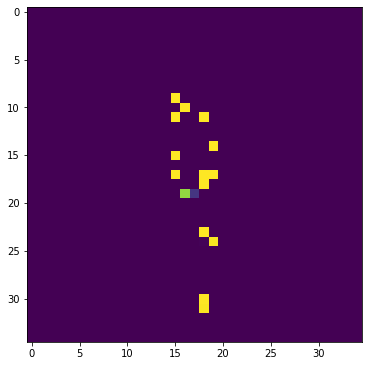

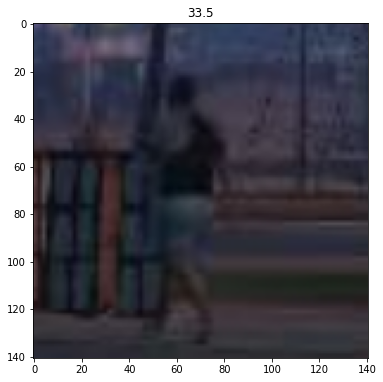

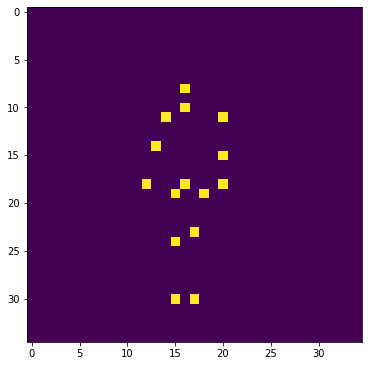

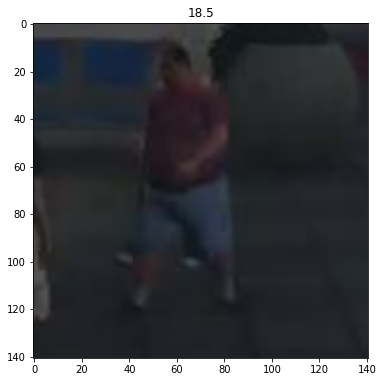

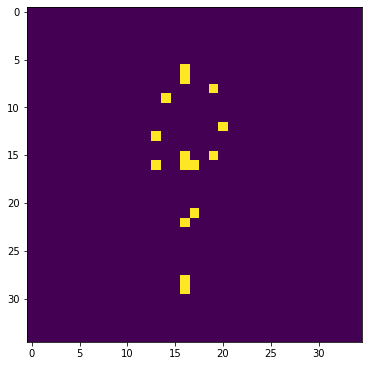

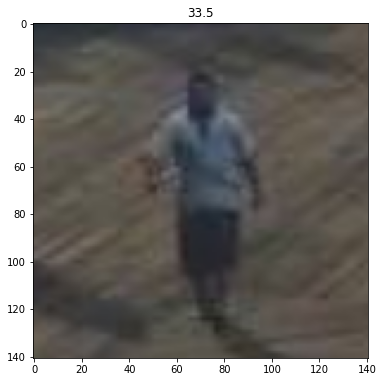

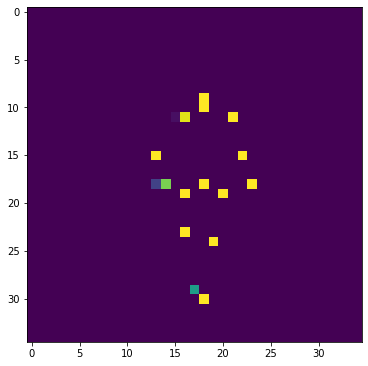

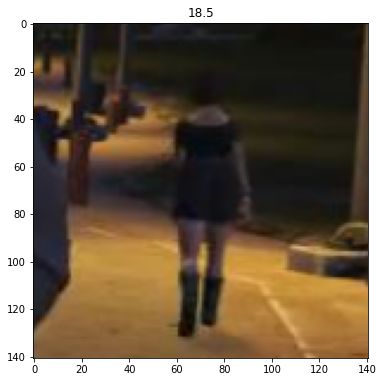

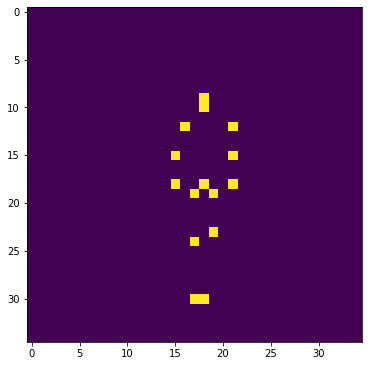

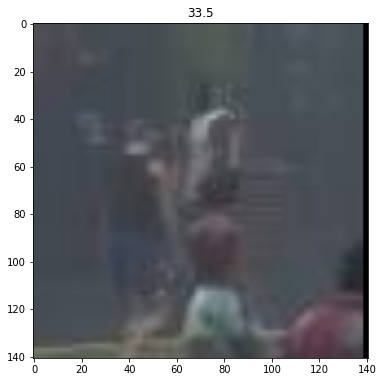

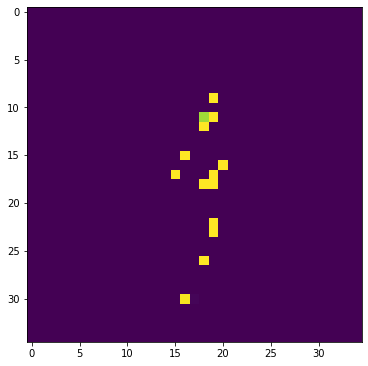

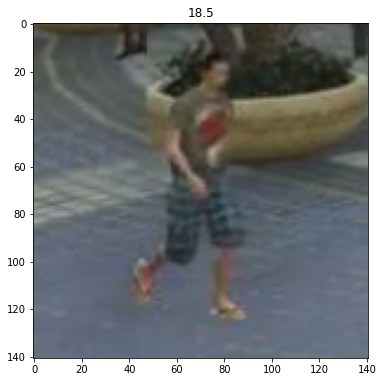

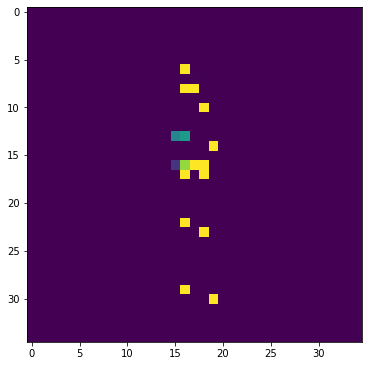

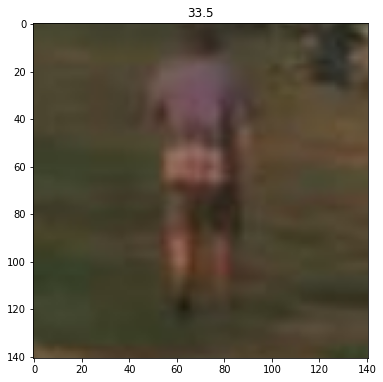

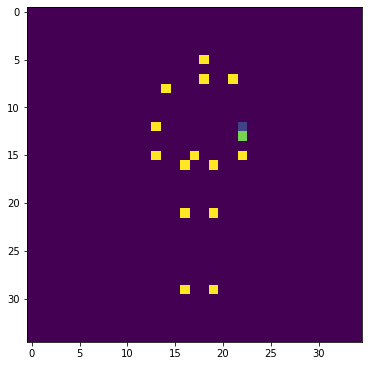

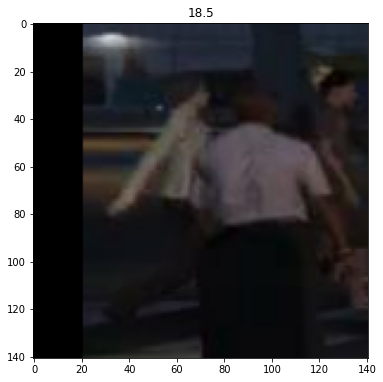

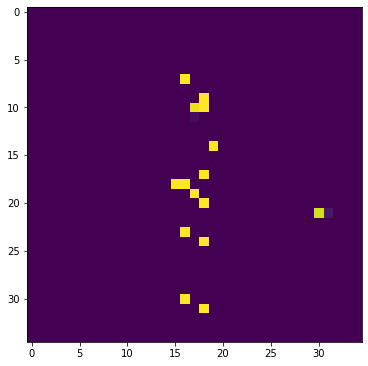

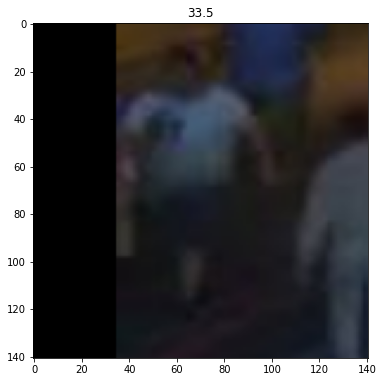

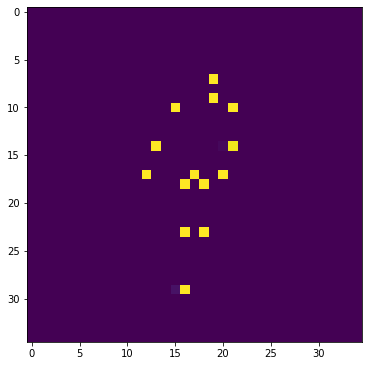

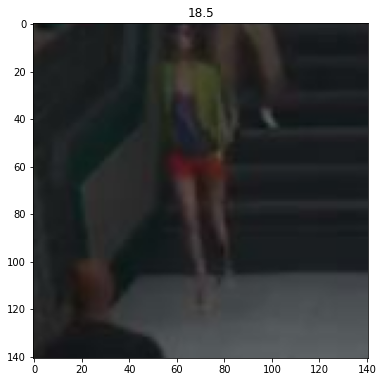

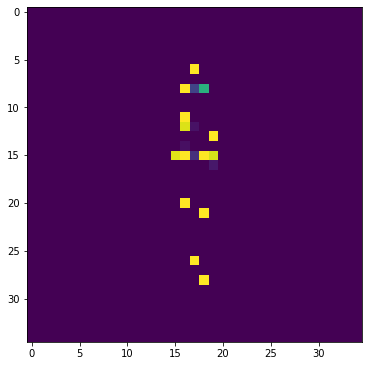

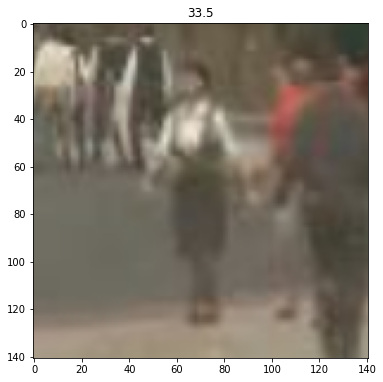

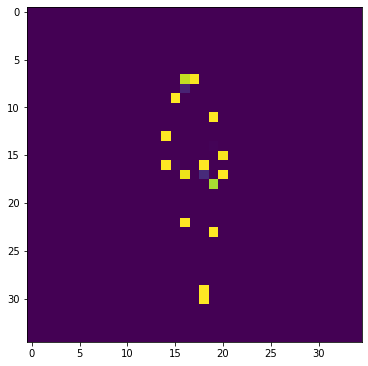

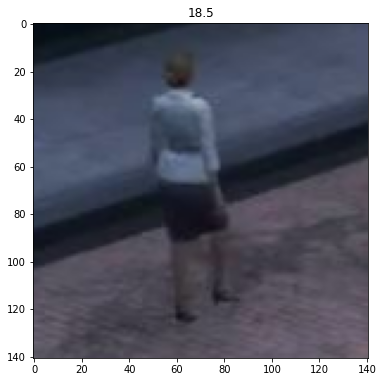

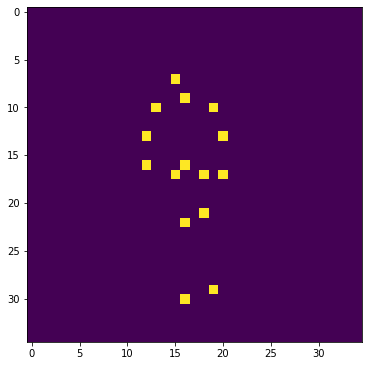

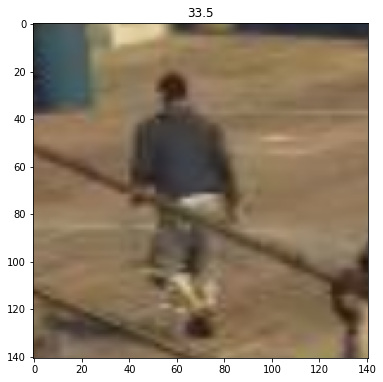

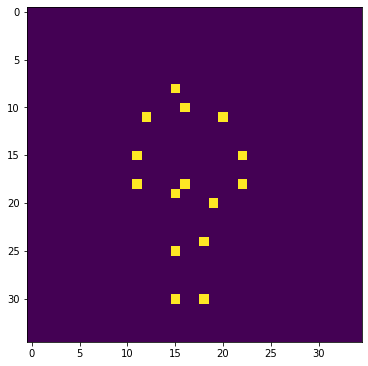

In [157]:
for i in range(20,50,1):
    plt.imshow(persons[i].numpy())
    plt.title(str(cut_dist_pe[i]))
    plt.show()
    plt.imshow(poses[i].numpy()[:,:,0])
    plt.show()

In [11]:
def pack_dict(key_name, values):
    packed_dict = dict(zip(zip([key_name]*keypoint_count,range(keypoint_count)), values))
    return packed_dict

data1 = {'detection_loss': detection_loss,
        'cut_dist': cut_dist,
        'step': steps,
       }

data2 = {
        'step_kp': steps_kp,
        }
data2.update(pack_dict('keypoints_x', keypoints_x))
data2.update(pack_dict('keypoints_y', keypoints_y))
data2.update(pack_dict('keypoints_z', keypoints_z))

data2.update(pack_dict('keypoints_x_gt', keypoints_x_gt))
data2.update(pack_dict('keypoints_y_gt', keypoints_y_gt))
data2.update(pack_dict('keypoints_z_gt', keypoints_z_gt))

for item in data1.items():
    print(item[0],len(item[1]))
    
for item in data2.items():
    print(item[0],len(item[1]))

df1 = pd.DataFrame(data1)
df2 = pd.DataFrame(data2)

detection_loss 5000
cut_dist 5000
step 5000
step_kp 7921
('keypoints_x', 0) 7921
('keypoints_x', 1) 7921
('keypoints_x', 2) 7921
('keypoints_x', 3) 7921
('keypoints_x', 4) 7921
('keypoints_x', 5) 7921
('keypoints_x', 6) 7921
('keypoints_x', 7) 7921
('keypoints_x', 8) 7921
('keypoints_x', 9) 7921
('keypoints_x', 10) 7921
('keypoints_x', 11) 7921
('keypoints_x', 12) 7921
('keypoints_x', 13) 7921
('keypoints_x', 14) 7921
('keypoints_y', 0) 7921
('keypoints_y', 1) 7921
('keypoints_y', 2) 7921
('keypoints_y', 3) 7921
('keypoints_y', 4) 7921
('keypoints_y', 5) 7921
('keypoints_y', 6) 7921
('keypoints_y', 7) 7921
('keypoints_y', 8) 7921
('keypoints_y', 9) 7921
('keypoints_y', 10) 7921
('keypoints_y', 11) 7921
('keypoints_y', 12) 7921
('keypoints_y', 13) 7921
('keypoints_y', 14) 7921
('keypoints_z', 0) 7921
('keypoints_z', 1) 7921
('keypoints_z', 2) 7921
('keypoints_z', 3) 7921
('keypoints_z', 4) 7921
('keypoints_z', 5) 7921
('keypoints_z', 6) 7921
('keypoints_z', 7) 7921
('keypoints_z', 8) 79

In [12]:
print(df1)
print(df2)


      detection_loss  cut_dist  step
0           4.458006       5.0     1
1          32.001350       6.5     2
2           3.176319       8.0     3
3          21.380892       9.5     4
4           7.247294      11.0     5
...              ...       ...   ...
4995        0.035251      27.5  4996
4996       34.290501      29.0  4997
4997       22.970484      30.5  4998
4998       37.011906      32.0  4999
4999        1.589817      33.5  5000

[5000 rows x 3 columns]
      step_kp  (keypoints_x, 0)  (keypoints_x, 1)  (keypoints_x, 2)  \
0           1        -10.000000              -6.0         -6.000000   
1           2          2.000000               2.0          2.000000   
2           3        -10.000000             -10.0         -9.610438   
3           4          2.000000               2.0          2.000000   
4           4          2.000000               2.0          2.000000   
...       ...               ...               ...               ...   
7916     4998          2.000000   

In [13]:
pd.__version__

'1.0.3'

In [14]:
df = pd.merge(df2, df1, validate='m:1', right_on=df1.step, left_on=df2.step_kp)

In [15]:
df

key_0  step_kp  (keypoints_x, 0)  (keypoints_x, 1)  (keypoints_x, 2)  \
0         1        1        -10.000000              -6.0         -6.000000   
1         2        2          2.000000               2.0          2.000000   
2         3        3        -10.000000             -10.0         -9.610438   
3         4        4          2.000000               2.0          2.000000   
4         4        4          2.000000               2.0          2.000000   
...     ...      ...               ...               ...               ...   
7916   4998     4998          2.000000               2.0          6.000000   
7917   4999     4999         -6.000000              -6.0          1.999958   
7918   4999     4999          1.999994               2.0         -2.000000   
7919   4999     4999         -5.990942              -6.0         -6.000000   
7920   5000     5000         -6.000000              -6.0         -6.000000   

      (keypoints_x, 3)  (keypoints_x, 4)  (keypoints_x, 5)  (keypoints_x, 6)  \
0             9.999998        -22.000000              14.0        -22.000000   
1             5.999743         -2.000001              10.0         -2.000000   
2           -19.341402          2.000000             -26.0          6.000000   
3            -6.000000         10.000000             -18.0         18.000000   
4            -9.875425          6.000000             -10.0         14.000000   
...                ...               ...               ...               ...   
7916         18.000000        -13.937755              26.0        -14.000000   
7917         -6.000000          2.000000              -6.0         -1.997759   
7918          2.000000          1.989774               2.0        -13.977716   
7919        -10.896561          2.000000             -14.0          6.000000   
7920         -6.000000        -10.000010               6.0        -14.000000   

      (keypoints_x, 7)  ...  (keypoints_z_gt, 8)  (keypoints_z_gt, 9)  \
0            14.000000  ...             0.420000             0.830000   
1             9.998049  ...             0.220000             0.570000   
2           -26.000000  ...            -1.130000            -1.030000   
3           -18.000000  ...             0.170000             0.070000   
4           -11.447815  ...            -0.740000            -0.640000   
...                ...  ...                  ...                  ...   
7916         26.000000  ...            -0.600000            -0.809999   
7917         -9.826747  ...            -0.219999            -0.590000   
7918          5.684013  ...             0.770000             0.450001   
7919        -14.000000  ...             0.470001             0.130001   
7920          6.000000  ...            -0.990002            -0.709999   

      (keypoints_z_gt, 10)  (keypoints_z_gt, 11)  (keypoints_z_gt, 12)  \
0                 0.660000              0.900000              0.760000   
1                 0.550000              0.390000              0.660000   
2                -1.080000             -1.100000             -1.090000   
3                 0.130000              0.380000              0.180000   
4                -0.730000             -0.310000             -0.590000   
...                    ...                   ...                   ...   
7916             -0.870001             -0.430000             -0.830000   
7917             -0.410000             -0.459999             -0.209999   
7918              0.619999              0.580002              0.810001   
7919              0.310001              0.259998              0.500000   
7920             -0.790001             -0.709999             -0.830002   

      (keypoints_z_gt, 13)  (keypoints_z_gt, 14)  detection_loss  cut_dist  \
0                 0.780000              0.840000        4.458006       5.0   
1                 0.280000              0.780000       32.001350       6.5   
2                -0.830000             -1.020000        3.176319       8.0   
3                 0.720000    

In [16]:
cut_df = df.groupby(df.cut_dist)

Text(0, 0.5, 'Fehler')

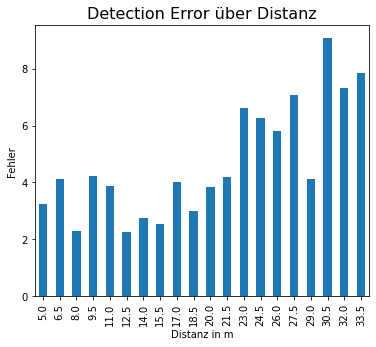

In [152]:
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)
(cut_df.detection_loss.mean()-12).plot.bar(ax=ax)
ax.set_title("Detection Error über Distanz", fontsize=16)
ax.set_xlabel('Distanz in m')
ax.set_ylabel('Fehler')

In [18]:
for k in range(keypoint_count):
    df[("loss", 'keypoints_x',k)] = np.abs(df[('keypoints_x',k)] - df[('keypoints_x_gt',k)])
    df[("loss", 'keypoints_y',k)] = np.abs(df[('keypoints_y',k)] - df[('keypoints_y_gt',k)])
    df[("loss", 'keypoints_z',k)] = np.abs(df[('keypoints_z',k)] - df[('keypoints_z_gt',k)])

In [19]:
for k in range(keypoint_count):
    df[("loss", 'keypoints_xy',k)] = np.sqrt(df[('loss', 'keypoints_x', k)]**2 + df[('loss', 'keypoints_y', k)]**2)

In [20]:
colums_x = []
for k in range(keypoint_count):
    colums_x.append(("loss", 'keypoints_x',k))

df[("loss", 'keypoints_x')] = df[colums_x].mean(axis=1)

colums_y = []
for k in range(keypoint_count):
    colums_y.append(("loss", 'keypoints_y',k))

df[("loss", 'keypoints_y')] = df[colums_y].mean(axis=1)

colums_z = []
for k in range(keypoint_count):
    colums_z.append(("loss", 'keypoints_z',k))

df[("loss", 'keypoints_z')] = df[colums_z].mean(axis=1)

colums_xy = []
for k in range(keypoint_count):
    colums_xy.append(("loss", 'keypoints_xy',k))

df[("loss", 'keypoints_xy')] = df[colums_xy].mean(axis=1)


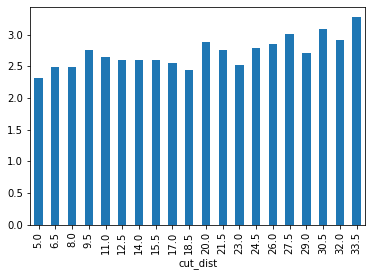

In [21]:
cut_df = df.groupby(df.cut_dist)
(cut_df.mean()[('loss', 'keypoints_x')]-4).plot.bar()

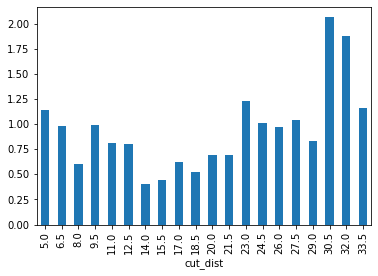

In [22]:
(cut_df.mean()[('loss', 'keypoints_y')]-4).plot.bar()

Text(0, 0.5, 'Fehler')

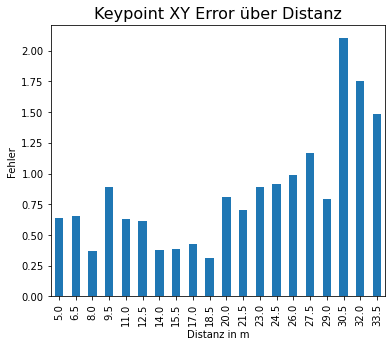

In [156]:
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)
(cut_df.mean()[('loss', 'keypoints_xy')]-8.5).plot.bar(ax=ax)
ax.set_title("Keypoint XY Error über Distanz", fontsize=16)
ax.set_xlabel('Distanz in m')
ax.set_ylabel('Fehler')

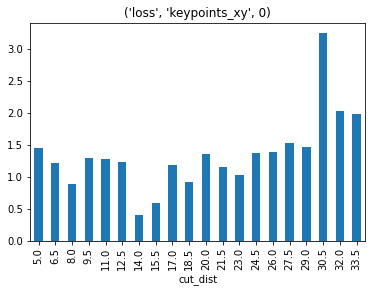

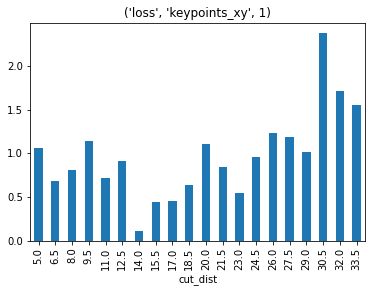

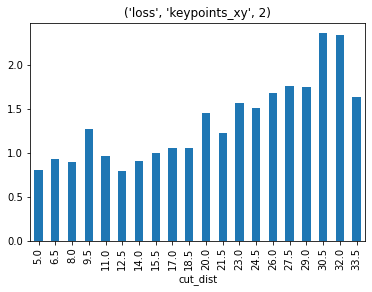

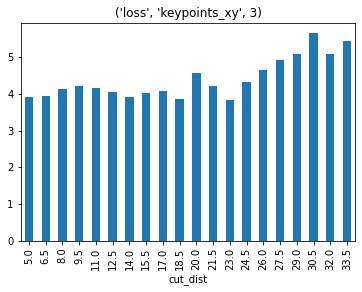

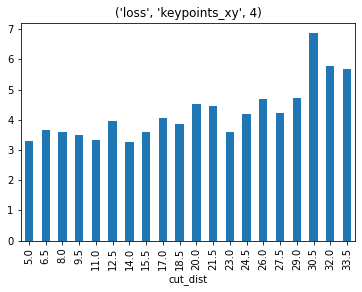

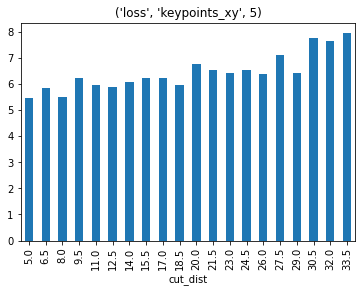

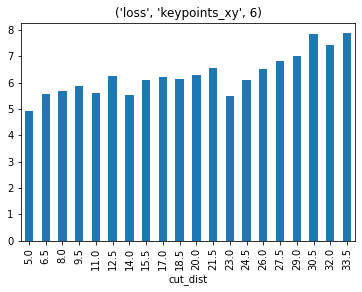

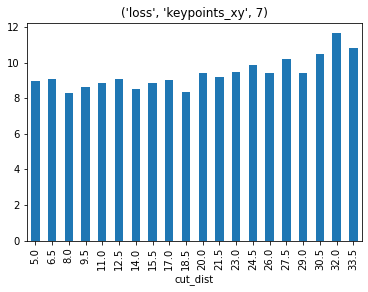

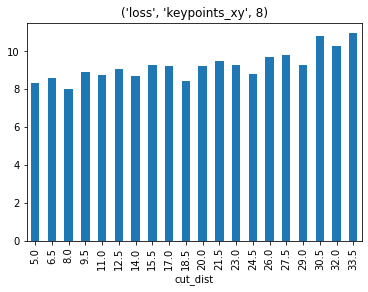

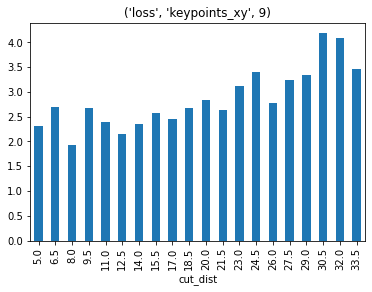

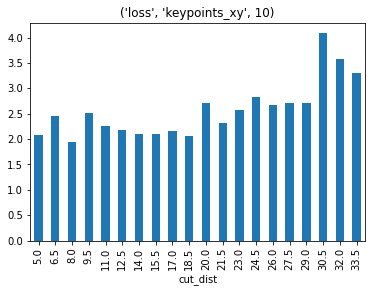

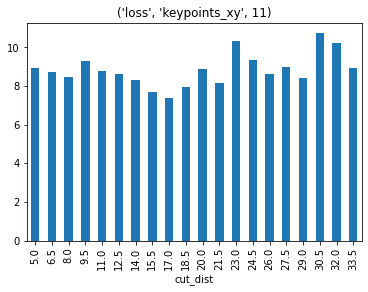

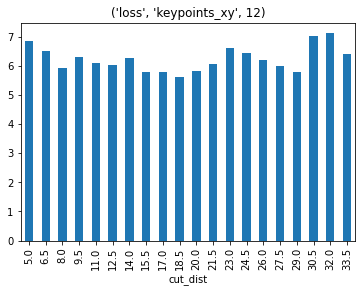

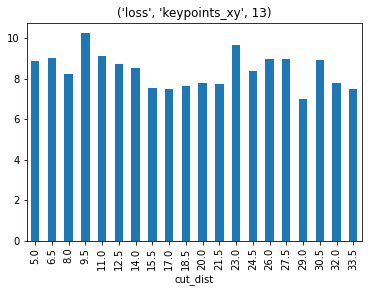

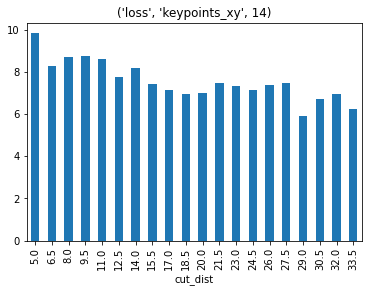

In [24]:
for colum in colums_xy:
    (cut_df.mean()[colum]-4).plot.bar()
    plt.title(str(colum))
    plt.show()

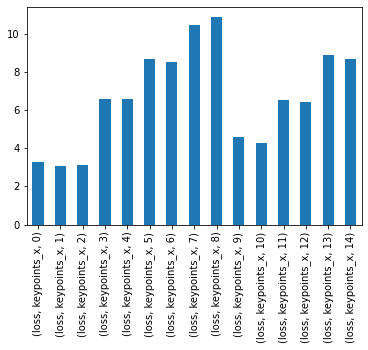

In [25]:
df.mean()[colums_x].plot.bar()


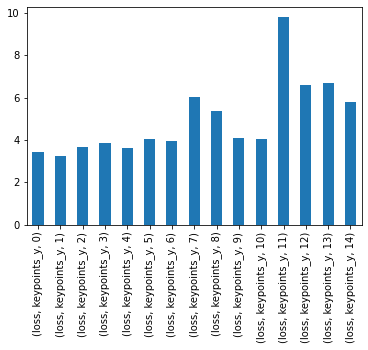

In [26]:
df.mean()[colums_y].plot.bar()

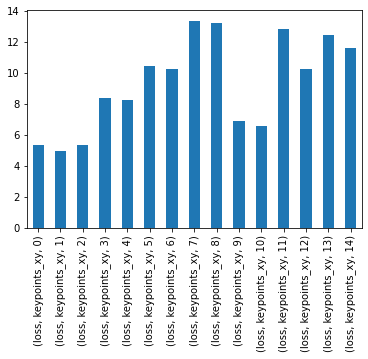

In [27]:
df.mean()[colums_xy].plot.bar()

In [28]:
kp = []
kp_gt = []
for k in range(keypoint_count):
    kp.append(df[('keypoints_z',k)])
    kp_gt.append(df[('keypoints_z_gt',k)])

kp = np.asarray(kp)
kp_gt = np.asarray(kp_gt)

In [29]:
print(kp.mean())
print(kp_gt.mean())

-0.14994466604369963
-0.024328997040549416


In [62]:
mpjpe_type = "gt"

In [63]:
import ShAReD_Net.data.transform.inverse_transform as inverse_transform

pose = np.empty([df.shape[0],keypoint_count,3], dtype=np.float32)
for k in range(keypoint_count):
    pos = np.asarray(df[[('keypoints_x',k),('keypoints_y',k),('keypoints_z',k)]])
    pose[:,k,:] = pos

img_pose = inverse_transform.cut_poses_to_img(pose, np.asarray(df.cut_dist, dtype=np.float32)[...,None,None], config.model.data.upscaling, config.dataset.cam_intr_f)
img_pose = img_pose.numpy()

pose_gt = np.empty([df.shape[0],keypoint_count,3], dtype=np.float32)
for k in range(keypoint_count):
    pos_gt = np.asarray(df[[('keypoints_x_gt',k),('keypoints_y_gt',k),('keypoints_z_gt',k)]])
    pose_gt[:,k,:] = pos_gt

img_pose_gt = inverse_transform.cut_poses_to_img(pose_gt, np.asarray(df.cut_dist, dtype=np.float32)[...,None,None], config.model.data.upscaling, config.dataset.cam_intr_f)
img_pose_gt = img_pose_gt.numpy()

if mpjpe_type == "gt":
    img_pose_gt[:,:,2] += np.asarray(df.cut_dist, dtype=np.float32)[...,None]
    img_pose[:,:,2] = img_pose_gt[:,:,2]
elif mpjpe_type == "3d":
    img_pose_gt[:,:,2] += np.asarray(df.cut_dist, dtype=np.float32)[...,None]
    img_pose[:,:,2] += np.asarray(df.cut_dist, dtype=np.float32)[...,None]
else:
    raise ValueError("not suported mpjpe_type defined")

Text(0, 0.5, 'Z Position in m')

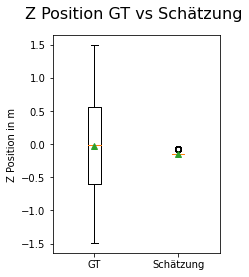

In [193]:
fig = plt.figure(figsize=(3,4))
fig.suptitle("Z Position GT vs Schätzung", fontsize=16)
ax = fig.add_subplot(111)
ax.boxplot([pose_gt.reshape([-1,3])[:,2],pose.reshape([-1,3])[:,2]], labels =['GT', 'Schätzung'], showmeans=True)
ax.set_ylabel('Z Position in m')

In [64]:
real_mm = inverse_transform.poses_to_real(img_pose, config.dataset.inverse_cam_transforme)*1000

real_mm_gt = inverse_transform.poses_to_real(img_pose_gt, config.dataset.inverse_cam_transforme)*1000


In [33]:
limb_connections = tf.constant([0,
                                0,
                                1,
                                1,
                                1,
                                3,
                                4,
                                5,
                                6,
                                2,
                                2,
                                9,
                                10,
                                11,
                                12,
                                ],dtype=tf.int32)

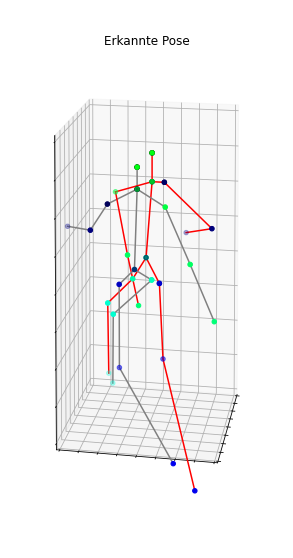

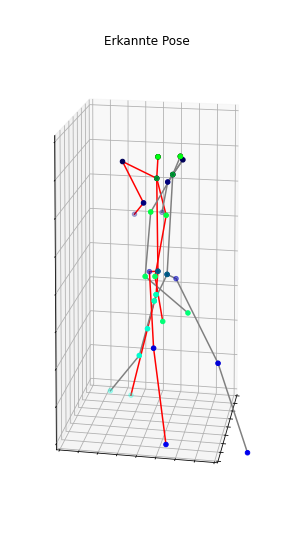

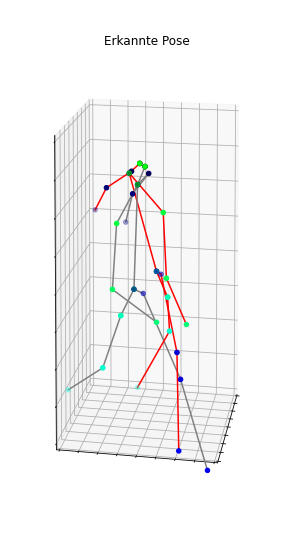

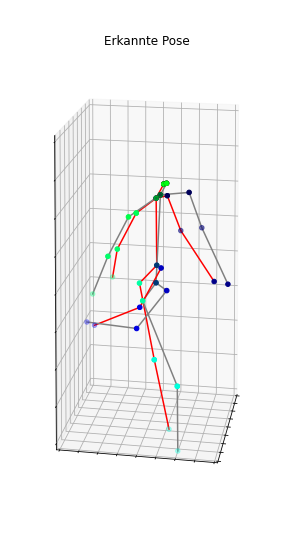

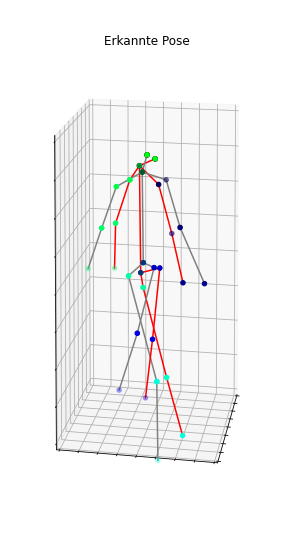

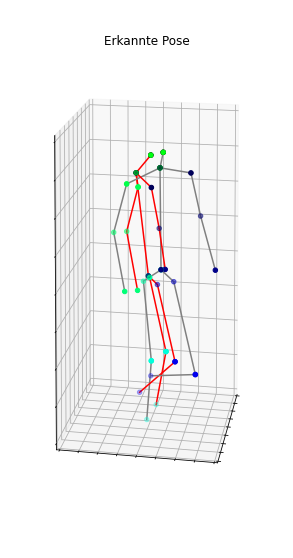

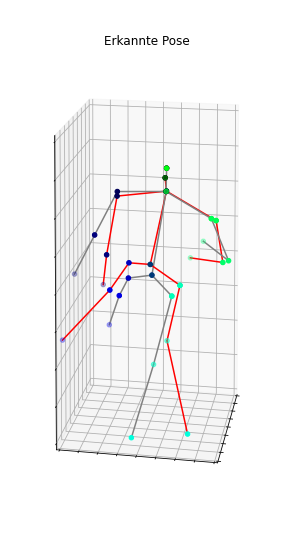

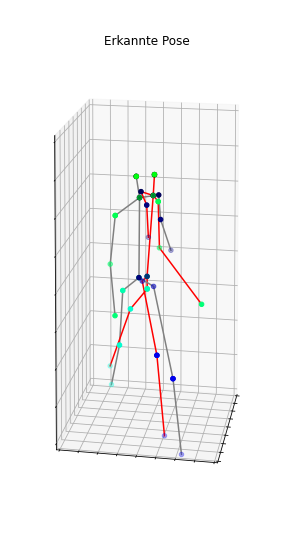

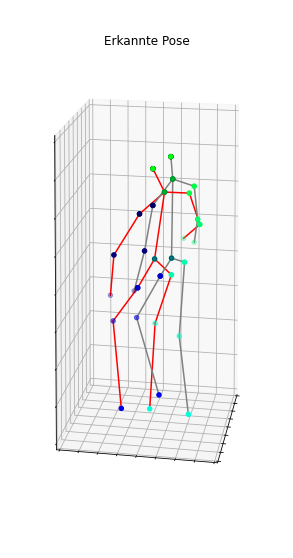

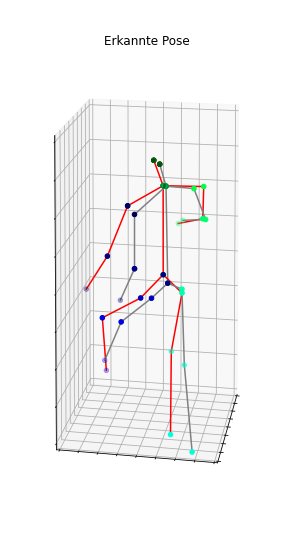

In [197]:
def pose_plot(pose, pose_gt, ax):
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    ax.axes.zaxis.set_ticklabels([])
    center = pose.mean(0)
    center_gt = pose.mean(0)
    kp = len(limb_connections)
    for limb_start,limb_end in enumerate(limb_connections):
        # Data for a three-dimensional line
        x = pose[[limb_start,limb_end],0] - center[0]
        y = pose[[limb_start,limb_end],1] - center[1]
        z = pose[[limb_start,limb_end],2] - center[2]
        ax.plot3D(-z,x,-y, 'red')
        ax.scatter3D(-z, x, -y, c=[[0,limb_start%2,limb_start/kp]]);
        
        x = pose_gt[[limb_start,limb_end],0] - center_gt[0]
        y = pose_gt[[limb_start,limb_end],1] - center_gt[1]
        z = pose_gt[[limb_start,limb_end],2] - center_gt[2]
        ax.plot3D(-z,x,-y, 'gray')
        ax.scatter3D(-z, x, -y, c=[[0,limb_start%2,limb_start/kp]]);
    ax.set(xlim=(-400, 400), ylim=(-400, 400), zlim=(-800, 800))
    ax.view_init(10, 10)

for i in range(20,30):
    fig = plt.figure(figsize=(5,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title(f"Erkannte Pose")
    pose_plot(real_mm[i].numpy(), real_mm_gt[i].numpy(), ax)
    plt.show()


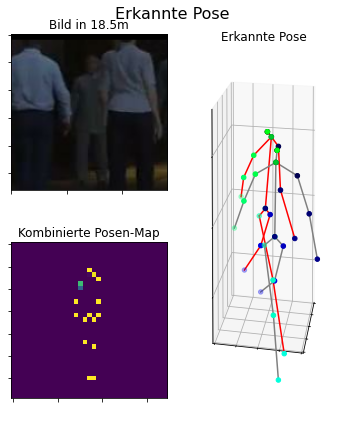

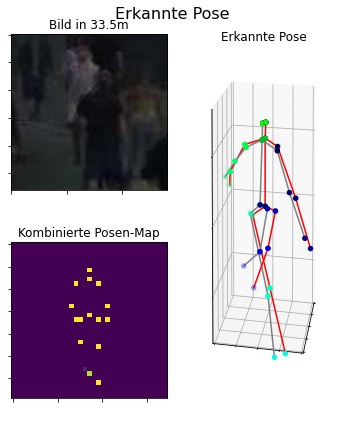

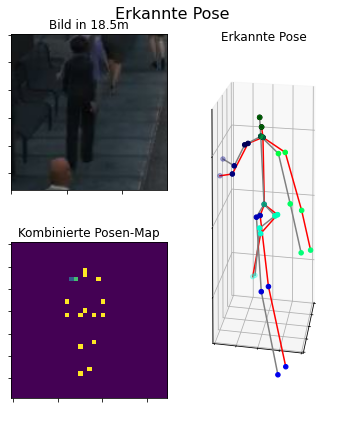

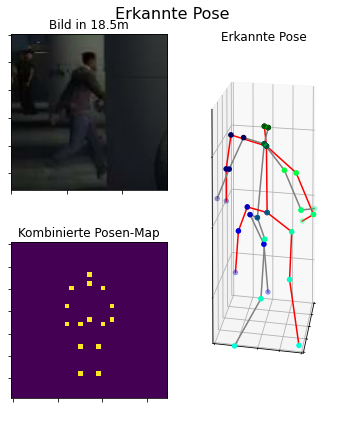

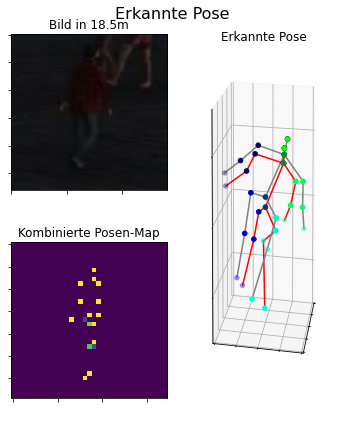

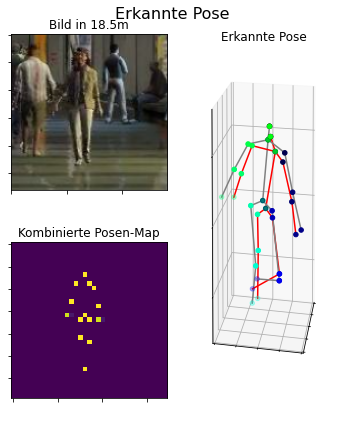

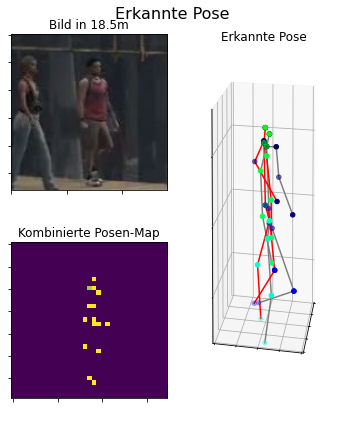

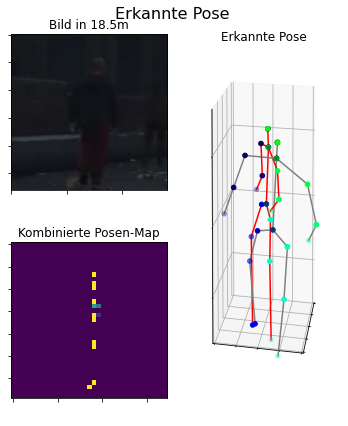

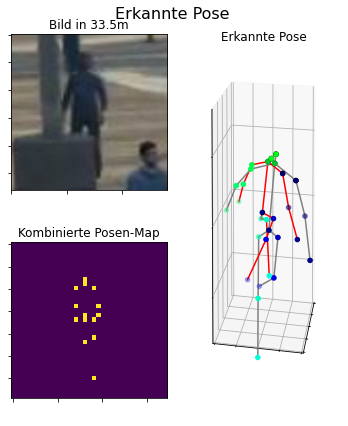

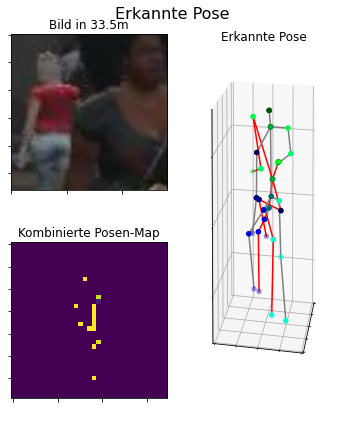

In [200]:
for n in range(0,10):
    i = np.random.randint(len(persons))
    fig = plt.figure(figsize=(5,6))
    fig.suptitle("Erkannte Pose", fontsize=16)
    gs = fig.add_gridspec(nrows=2, ncols=2)
    
    ax = fig.add_subplot(gs[0,0])
    ax.imshow(persons[i].numpy())
    ax.set_title(f"Bild in {cut_dist_pe[i]}m")
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    
    ax = fig.add_subplot(gs[1,0])
    ax.imshow(poses[i].numpy()[:,:,0])
    ax.set_title(f"Kombinierte Posen-Map")
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    
    ax = fig.add_subplot(gs[:,1], projection='3d')
    ax.set_title(f"Erkannte Pose")
    pose_plot(real_mm[steps_pe[i] == np.array(steps_kp)][0].numpy(), real_mm_gt[steps_pe[i] == np.array(steps_kp)][0].numpy(), ax)
    fig.tight_layout()
    plt.show()

    

[ 61.481426  59.289757  72.766045  98.08338   98.77624  119.88615
 116.91923  160.54071  152.97572   92.89728   90.59677  184.60222
 148.18016  163.3256   147.09401 ]
111.84864


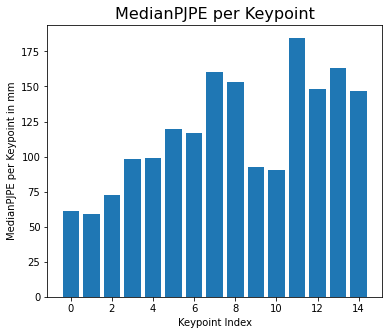

In [65]:
sq_err = (real_mm - real_mm_gt)**2
eucl_err = np.sqrt(sq_err[:,:,0] + sq_err[:,:,1] + sq_err[:,:,2])
per_kp_median_pjpe = np.median(eucl_err,axis=[0])
print(per_kp_median_pjpe)
median_pjpe = np.median(eucl_err,axis=[0,1])
print(median_pjpe)

plt.bar([i for i in range(keypoint_count)],per_kp_median_pjpe)
fig = plt.gcf()
fig.set_size_inches(6,5)
ax = fig.axes[0]
ax.set_title("MedianPJPE per Keypoint", fontsize=16)
ax.set_xlabel('Keypoint Index')
ax.set_ylabel('MedianPJPE per Keypoint in mm')

plt.show()

[ 82.62796   77.02692   83.271576 130.47798  127.49241  162.8549
 159.66493  208.50125  206.14871  107.06164  102.28297  200.87355
 159.94241  195.30278  182.26537 ]
145.71968


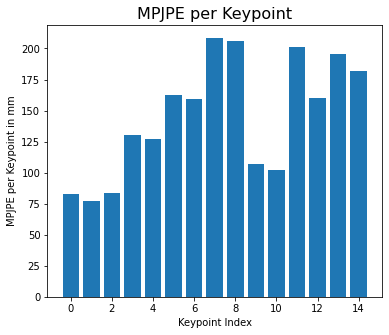

In [66]:
per_kp_mpjpe = np.mean(eucl_err,axis=0)
print(per_kp_mpjpe)
mpjpe = np.mean(per_kp_mpjpe)
print(mpjpe)

plt.bar([i for i in range(keypoint_count)],per_kp_mpjpe)
fig = plt.gcf()
fig.set_size_inches(6,5)
ax = fig.axes[0]
ax.set_title("MPJPE per Keypoint", fontsize=16)
ax.set_xlabel('Keypoint Index')
ax.set_ylabel('MPJPE per Keypoint in mm')

plt.show()

In [67]:
real_mm_center = np.mean(real_mm,axis=1)
real_mm_gt_center = np.mean(real_mm_gt,axis=1)

[ 69.11828   62.502235  38.423695  89.26637   94.45972  106.61192
 104.633705 140.11885  130.66608   59.49255   58.61014  146.17146
 112.757454 139.43965  128.46123 ]
91.334724


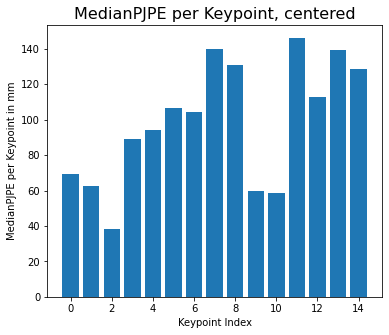

In [68]:

sq_err_center = ((real_mm - real_mm_center[:,None,:]) - (real_mm_gt - real_mm_gt_center[:,None,:]))**2
eucl_err_center = np.sqrt(sq_err_center[:,:,0] + sq_err_center[:,:,1] + sq_err_center[:,:,2])
per_kp_median_pjpe_center = np.median(eucl_err_center,axis=[0])
print(per_kp_median_pjpe_center)
median_pjpe_center = np.median(eucl_err_center,axis=[0,1])
print(median_pjpe_center)

plt.bar([i for i in range(keypoint_count)],per_kp_median_pjpe_center)
fig = plt.gcf()
fig.set_size_inches(6,5)
ax = fig.axes[0]
ax.set_title("MedianPJPE per Keypoint, centered", fontsize=16)
ax.set_xlabel('Keypoint Index')
ax.set_ylabel('MedianPJPE per Keypoint in mm')

plt.show()

[ 80.300766  70.94207   43.430584 116.26605  119.77574  148.70917
 147.6028   190.32814  187.71135   72.86621   69.65796  164.94005
 125.90576  172.87177  163.33966 ]
124.97653


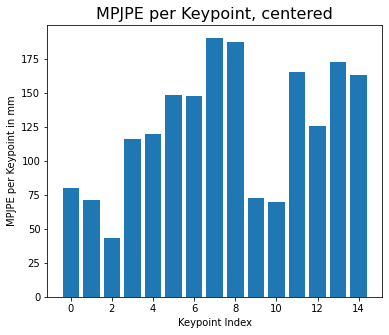

In [69]:
per_kp_mpjpe_center = np.mean(eucl_err_center,axis=0)
print(per_kp_mpjpe_center)
mpjpe_center = np.mean(per_kp_mpjpe_center)
print(mpjpe_center)

plt.bar([i for i in range(keypoint_count)],per_kp_mpjpe_center)
fig = plt.gcf()
fig.set_size_inches(6,5)
ax = fig.axes[0]
ax.set_title("MPJPE per Keypoint, centered", fontsize=16)
ax.set_xlabel('Keypoint Index')
ax.set_ylabel('MPJPE per Keypoint in mm')

plt.show()

[104.766846  77.037094   0.      ]


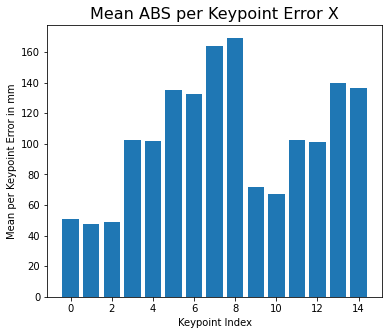

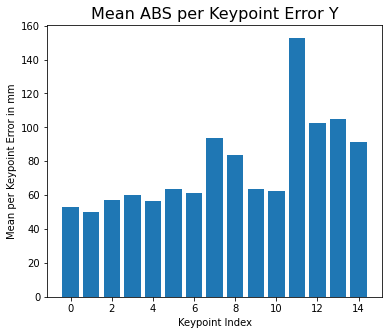

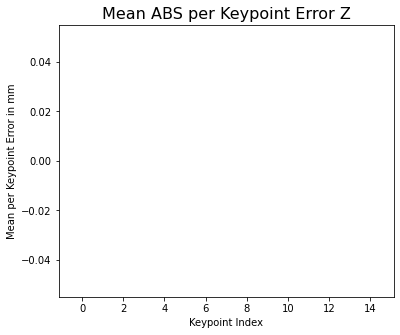

In [41]:
per_kp_abs_mean_x_y = np.mean(np.abs(real_mm - real_mm_gt),axis=0)

abs_mean_x_y = per_kp_abs_mean_x_y.mean(0)
print(abs_mean_x_y)

plt.bar([i for i in range(keypoint_count)],per_kp_abs_mean_x_y[:,0])
fig = plt.gcf()
fig.set_size_inches(6,5)
ax = fig.axes[0]
ax.set_title("Mean ABS per Keypoint Error X", fontsize=16)
ax.set_xlabel('Keypoint Index')
ax.set_ylabel('Mean per Keypoint Error in mm')

plt.show()

plt.bar([i for i in range(keypoint_count)],per_kp_abs_mean_x_y[:,1])
fig = plt.gcf()
fig.set_size_inches(6,5)
ax = fig.axes[0]
ax.set_title("Mean ABS per Keypoint Error Y", fontsize=16)
ax.set_xlabel('Keypoint Index')
ax.set_ylabel('Mean per Keypoint Error in mm')

plt.show()

plt.bar([i for i in range(keypoint_count)],per_kp_abs_mean_x_y[:,2])
fig = plt.gcf()
fig.set_size_inches(6,5)
ax = fig.axes[0]
ax.set_title("Mean ABS per Keypoint Error Z", fontsize=16)
ax.set_xlabel('Keypoint Index')
ax.set_ylabel('Mean per Keypoint Error in mm')

plt.show()

[77.08203  52.257812  0.      ]
[65.822266 57.65918   0.      ]


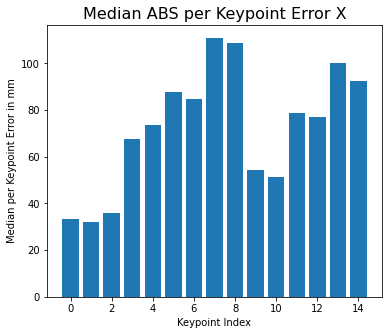

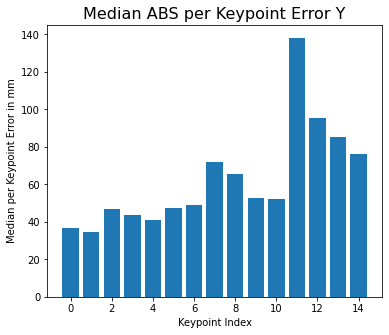

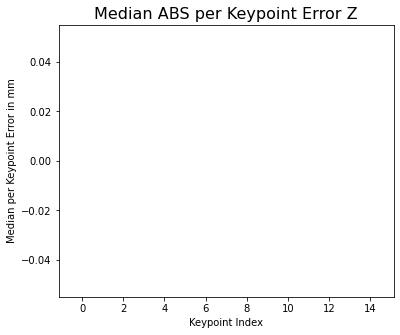

In [42]:
per_kp_abs_median_x_y = np.median(np.abs(real_mm - real_mm_gt),axis=[0])

abs_median_x_y = np.median(per_kp_abs_median_x_y,axis=[0])
print(abs_median_x_y)
abs_median_x_y = np.median(np.abs(real_mm - real_mm_gt),axis=[0,1])
print(abs_median_x_y)

plt.bar([i for i in range(keypoint_count)],per_kp_abs_median_x_y[:,0])
fig = plt.gcf()
fig.set_size_inches(6,5)
ax = fig.axes[0]
ax.set_title("Median ABS per Keypoint Error X", fontsize=16)
ax.set_xlabel('Keypoint Index')
ax.set_ylabel('Median per Keypoint Error in mm')

plt.show()

plt.bar([i for i in range(keypoint_count)],per_kp_abs_median_x_y[:,1])
fig = plt.gcf()
fig.set_size_inches(6,5)
ax = fig.axes[0]
ax.set_title("Median ABS per Keypoint Error Y", fontsize=16)
ax.set_xlabel('Keypoint Index')
ax.set_ylabel('Median per Keypoint Error in mm')

plt.show()

plt.bar([i for i in range(keypoint_count)],per_kp_abs_median_x_y[:,2])
fig = plt.gcf()
fig.set_size_inches(6,5)
ax = fig.axes[0]
ax.set_title("Median ABS per Keypoint Error Z", fontsize=16)
ax.set_xlabel('Keypoint Index')
ax.set_ylabel('Median per Keypoint Error in mm')

plt.show()

In [43]:
person_sizes = np.sqrt(pose_gt[:,:,0]**2 + pose_gt[:,:,1]**2)

In [44]:
max_person_sizes = np.max(person_sizes,1)

Text(0, 0.5, 'Häufigkeit')

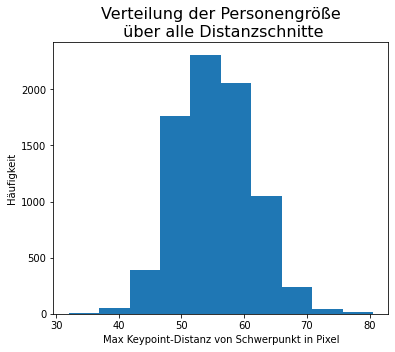

In [45]:
fig = plt.figure(figsize=(6,5))

ax = fig.add_subplot(111)
ax.hist(max_person_sizes)

ax.set_title("Verteilung der Personengröße\n über alle Distanzschnitte", fontsize=16)
ax.set_xlabel('Max Keypoint-Distanz von Schwerpunkt in Pixel')
ax.set_ylabel('Häufigkeit')

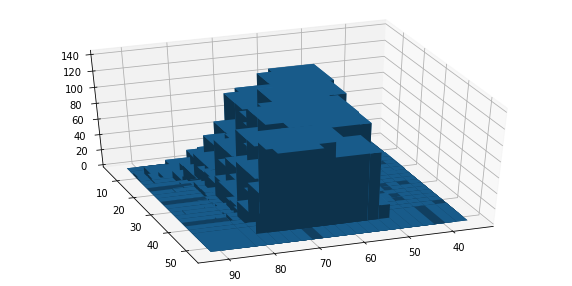

In [46]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111, projection='3d')

hist, xedges, yedges = np.histogram2d(max_person_sizes,  df.cut_dist, bins=20, range=[[30, 80], [0, 40]])

size = 10
# Construct arrays for the anchor positions of the 16 bars.
xpos, ypos = np.meshgrid(xedges[:-1] + size/2, yedges[:-1] + size/2, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

# Construct arrays with the dimensions for the 16 bars.
dx = dy = size * np.ones_like(zpos)
dz = hist.ravel()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')

ax.view_init(40, 70)
plt.show()

Text(0.5, 0.98, '')

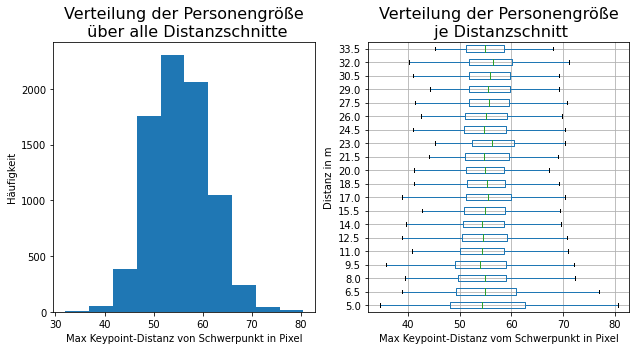

In [144]:
fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(121)
ax.hist(max_person_sizes)

ax.set_title("Verteilung der Personengröße\n über alle Distanzschnitte", fontsize=16)
ax.set_xlabel('Max Keypoint-Distanz von Schwerpunkt in Pixel')
ax.set_ylabel('Häufigkeit')

ax = fig.add_subplot(122)
max_person_sizes_df = pd.DataFrame({'max_person_sizes':max_person_sizes, 'cut_dist': df.cut_dist})
#ax.scatter(max_person_sizes,  df.cut_dist)
max_person_sizes_df_grouped = max_person_sizes_df.groupby('cut_dist')#.max_person_sizes

max_person_sizes_df.boxplot(by = 'cut_dist', column = 'max_person_sizes',vert=False, showfliers = False, ax = ax)
ax.set_title("Verteilung der Personengröße\n je Distanzschnitt", fontsize=16)
ax.set_xlabel('Max Keypoint-Distanz vom Schwerpunkt in Pixel')
ax.set_ylabel('Distanz in m')
fig.suptitle("")

In [428]:
z_pos_to_size = pd.DataFrame({'Personen Z Position':pose_gt[:,:,2].mean(1), 'Personen Größe':max_person_sizes.astype(np.int32)})

In [437]:
z_pos_to_size['Position Groups'] = pd.cut(z_pos_to_size['Personen Z Position'], bins=bins,precision=1)
z_pos_to_size['Size Groups'] = pd.cut(z_pos_to_size['Personen Größe'], bins=bins,precision=0)

Position Groups
(-1.37, -1.23]     -3.250306
(-1.23, -1.092]    -2.925914
(-1.092, -0.954]   -2.594445
(-0.954, -0.816]   -2.242467
(-0.816, -0.678]   -1.901009
(-0.678, -0.541]   -1.551934
(-0.541, -0.403]   -1.198587
(-0.403, -0.265]   -0.851122
(-0.265, -0.127]   -0.489068
(-0.127, 0.0107]   -0.153694
(0.0107, 0.148]     0.195175
(0.148, 0.286]      0.558295
(0.286, 0.424]      0.895519
(0.424, 0.562]      1.260229
(0.562, 0.7]        1.603577
(0.7, 0.837]        1.947807
(0.837, 0.975]      2.302770
(0.975, 1.113]      2.643331
(1.113, 1.251]      2.988105
(1.251, 1.389]      3.264870
Name: Personen Z Position, dtype: float32

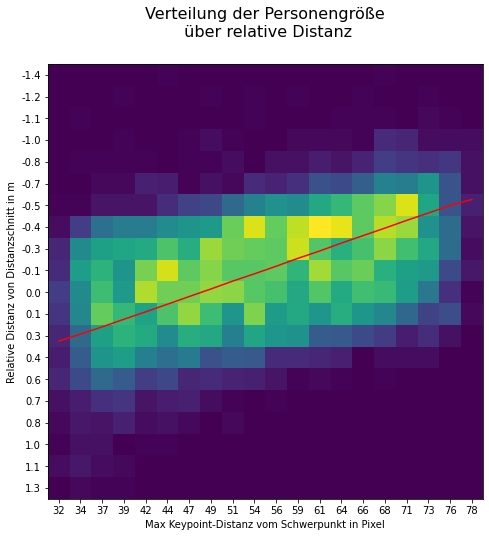

In [408]:
# plt.scatter(pose_gt[:,:,2].mean(1),max_person_sizes)

bins = 20
hist, binx, biny = np.histogram2d(np.asarray(max_person_sizes,np.float32),np.asarray(pose_gt[:,:,2].mean(1),np.float32), bins = bins)

fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot(111)
ax.matshow(hist)
ax.tick_params(axis='x', bottom=True,top=False, labelbottom=True, labeltop=False)
ax.set_title("Verteilung der Personengröße\n über relative Distanz", fontsize=16)
ax.set_ylabel('Relative Distanz von Distanzschnitt in m')
ax.set_xlabel('Max Keypoint-Distanz vom Schwerpunkt in Pixel')
ax.set_xticklabels(np.around(binx).astype(np.int32))
ax.set_yticklabels(np.around(biny,1))
bin_ticks = np.asarray([i for i in range(bins)])
ax.set_yticks(bin_ticks)
ax.set_xticks(bin_ticks)

groups = z_pos_to_size.groupby('Position Groups')
y_mean = groups.mean()['Personen Z Position']
y_max = biny.max()
y_min = biny.min()
y_mean_center = y_mean / (y_mean_max-y_mean_min)*(bins/2-3)

ax.plot(bin_ticks, -y_mean_center+bins/2-1, c="red")
y_mean_center

Text(0.5, 0.98, '')

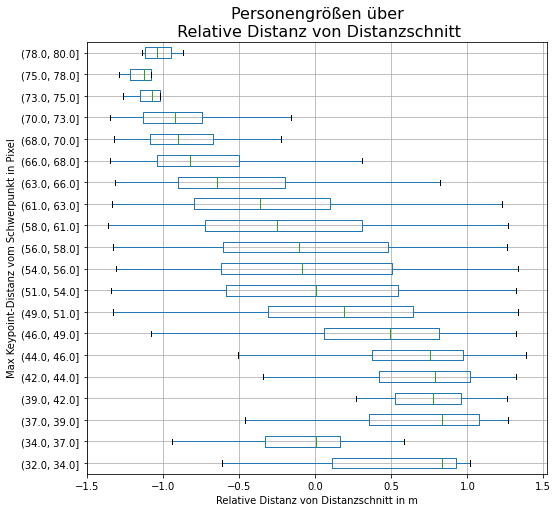

In [438]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)


z_pos_to_size.boxplot(by = 'Size Groups', column = 'Personen Z Position',vert=False, showfliers = False, ax = ax)
ax.set_title("Personengrößen über\n Relative Distanz von Distanzschnitt", fontsize=16)
ax.set_xlabel('Relative Distanz von Distanzschnitt in m')
ax.set_ylabel('Max Keypoint-Distanz vom Schwerpunkt in Pixel')
fig.suptitle("")

Text(0, 0.5, 'Fehler')

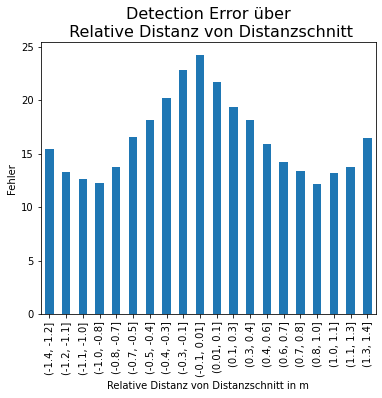

In [442]:
cut_df = df.groupby(z_pos_to_size['Position Groups'])

fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)
(cut_df.detection_loss.mean()).plot.bar(ax=ax)
ax.set_title("Detection Error über\n Relative Distanz von Distanzschnitt", fontsize=16)
ax.set_xlabel('Relative Distanz von Distanzschnitt in m')
ax.set_ylabel('Fehler')

In [48]:
import ipywidgets as widgets


In [49]:
progress = widgets.IntProgress(value=0,min=0,max=10)
display(progress)


IntProgress(value=0, max=10)

In [50]:
for i in range(progress.max + 1):
    progress.value=i

In [51]:
#%matplotlib notebook
%matplotlib inline
plt.rcParams["figure.figsize"] = 6, 11

(30, 8)


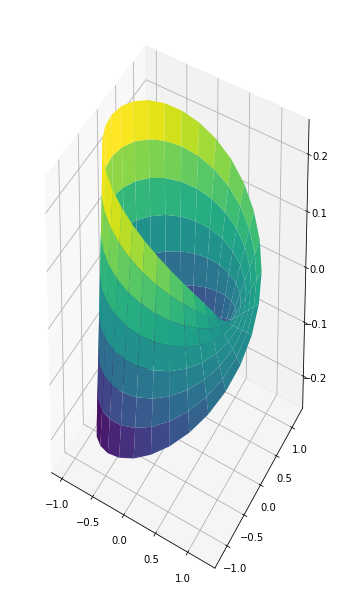

In [52]:
theta = np.linspace(0, 2 * np.pi, 30)
w = np.linspace(-0.25, 0.25, 8)
w, theta = np.meshgrid(w, theta)

phi = 0.5 * theta

# radius in x-y plane
r = 1 + w * np.cos(phi)

x = r * np.cos(theta)
y = r * np.sin(theta)
z = w * np.sin(phi)

print(x.shape)





ax = plt.axes(projection='3d')
ax.plot_surface(x, y, z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none');